In [3]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, MaxPooling2D, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import layers, models, regularizers
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
# Đường dẫn đến dữ liệu
data_dir = './chest_xray/'
labels = ['NORMAL', 'PNEUMONIA']
img_size = 150

In [6]:
# Hàm tiền xử lý dữ liệu
def load_data(directory):
    data = []
    for label in labels:
        path = os.path.join(directory, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_img = cv2.resize(img_array, (img_size, img_size))
                data.append([resized_img, class_num])
            except Exception as e:
                print(f'Lỗi: {e}')
    return np.array(data, dtype=object)

In [7]:
# Tải dữ liệu
train_data = load_data(os.path.join(data_dir, 'train'))
val_data = load_data(os.path.join(data_dir, 'val'))
test_data = load_data(os.path.join(data_dir, 'test'))


In [8]:
# Phân tách features và labels
x_train, y_train = zip(*train_data)
x_val, y_val = zip(*val_data)
x_test, y_test = zip(*test_data)

x_train = np.array(x_train) / 255.0
x_val = np.array(x_val) / 255.0
x_test = np.array(x_test) / 255.0

x_train = x_train.reshape(-1, img_size, img_size, 1)
x_val = x_val.reshape(-1, img_size, img_size, 1)
x_test = x_test.reshape(-1, img_size, img_size, 1)

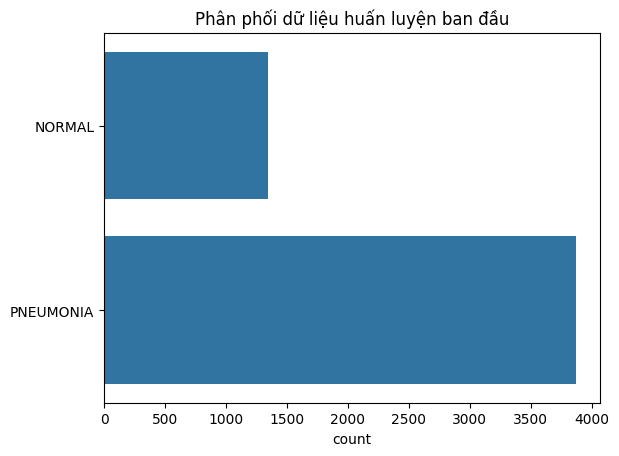

In [9]:
# Hiển thị phân phối dữ liệu trước khi cân bằng
sns.countplot([labels[i] for i in y_train])
plt.title('Phân phối dữ liệu huấn luyện ban đầu')
plt.show()

In [10]:
# Cân bằng dữ liệu bằng nhân bản dữ liệu thiểu số
count_classes = Counter(y_train)
max_count = max(count_classes.values())

x_train_balanced = []
y_train_balanced = []

for class_label in count_classes:
    class_indices = [i for i, label in enumerate(y_train) if label == class_label]
    num_to_add = max_count - count_classes[class_label]
    x_train_balanced.extend(x_train[class_indices])
    y_train_balanced.extend([class_label] * len(class_indices))
    
    extra_indices = np.random.choice(class_indices, num_to_add, replace=True)
    x_train_balanced.extend(x_train[extra_indices])
    y_train_balanced.extend([class_label] * num_to_add)

x_train_balanced = np.array(x_train_balanced)
y_train_balanced = np.array(y_train_balanced)


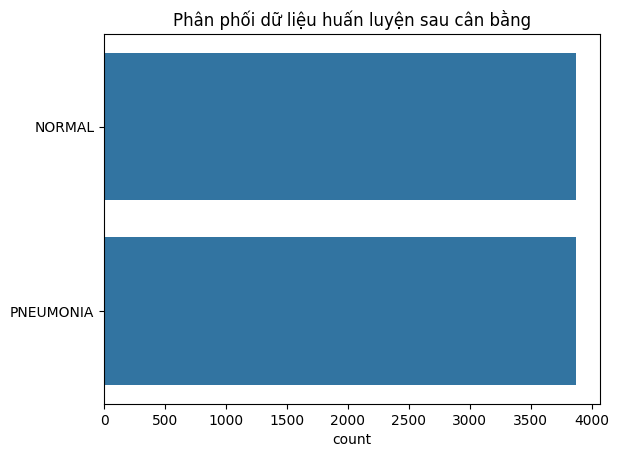

In [11]:
# Hiển thị phân phối dữ liệu sau khi cân bằng
sns.countplot([labels[i] for i in y_train_balanced])
plt.title('Phân phối dữ liệu huấn luyện sau cân bằng')
plt.show()

In [12]:
# 3. Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(x_train_balanced, y_train_balanced, batch_size=32)
val_generator = val_datagen.flow(x_val, y_val, batch_size=32)

In [21]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(7,7), padding='same', activation='relu', input_shape=(150, 150, 1)))
model.add(BatchNormalization())
model.add(Conv2D(16, kernel_size=(7,7), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.2))

model.add(Conv2D(32, kernel_size=(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(5,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Binary classification output

optimizer = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 150, 150, 16)      800       
                                                                 
 batch_normalization (Batch  (None, 150, 150, 16)      64        
 Normalization)                                                  
                                                                 
 conv2d_23 (Conv2D)          (None, 150, 150, 16)      12560     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 50, 50, 16)        0         
 ng2D)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 50, 50, 16)        0         
                                                                 
 conv2d_24 (Conv2D)          (None, 50, 50, 32)       

In [22]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_balanced),
    y=y_train_balanced
)

class_weights = dict(enumerate(class_weights))

In [23]:
# Huấn luyện mô hình
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
# Chuyển đổi y_train_balanced sang NumPy array đúng định dạng
y_train_balanced = np.array(y_train_balanced, dtype=np.int32)
y_val = np.array(y_val, dtype=np.float32)

history = model.fit(x_train_balanced, y_train_balanced,
    validation_data=(x_val, y_val),
    epochs=50, batch_size=32,
    callbacks=[early_stop, reduce_lr, checkpoint],
    class_weight=class_weights)

Epoch 1/50
243/243 [==============================] - 500s 2s/step - loss: 0.3528 - accuracy: 0.8506 - val_loss: 2.3241 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/50


c:\Users\ACER\anaconda3\envs\tensor\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


243/243 [==============================] - 448s 2s/step - loss: 0.1794 - accuracy: 0.9314 - val_loss: 2.7925 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/50
243/243 [==============================] - 436s 2s/step - loss: 0.1349 - accuracy: 0.9547 - val_loss: 1.3507 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 4/50
243/243 [==============================] - 423s 2s/step - loss: 0.1125 - accuracy: 0.9577 - val_loss: 1.5305 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 5/50
243/243 [==============================] - 451s 2s/step - loss: 0.1013 - accuracy: 0.9600 - val_loss: 0.8929 - val_accuracy: 0.6875 - lr: 1.0000e-04
Epoch 6/50
243/243 [==============================] - 423s 2s/step - loss: 0.0895 - accuracy: 0.9670 - val_loss: 0.1748 - val_accuracy: 0.9375 - lr: 1.0000e-04
Epoch 7/50
243/243 [==============================] - 394s 2s/step - loss: 0.0781 - accuracy: 0.9708 - val_loss: 0.2812 - val_accuracy: 0.8125 - lr: 1.0000e-04
Epoch 8/50
243/243 [==============================]

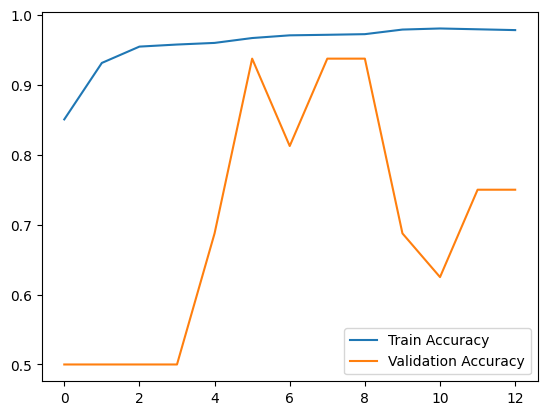

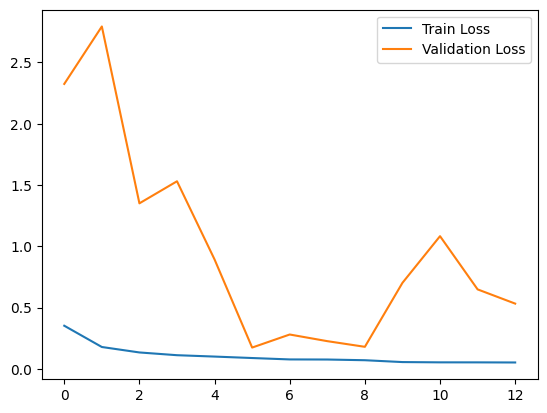

In [24]:
# Đánh giá mô hình
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [25]:
# Dự đoán và đánh giá trên tập kiểm tra
y_pred = (model.predict(x_test) > 0.5).astype('int32')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=labels))

20/20 [==============================] - 4s 198ms/step
[[153  81]
 [  7 383]]
              precision    recall  f1-score   support

      NORMAL       0.96      0.65      0.78       234
   PNEUMONIA       0.83      0.98      0.90       390

    accuracy                           0.86       624
   macro avg       0.89      0.82      0.84       624
weighted avg       0.87      0.86      0.85       624

